We are going to learn how to analyze queries and understand how to make them run much faster by using indexes. We will also learn how to maintain the database cleaned so that we don't run out of disk space and our query performance remains high.

We will use Postgres to work on a database from the **Department of Housing and Urban development (HUD)**. The database is already created and we will be analyzing its structure and then working on making querying it more efficient.

In this file, we will work on a real world data example using Postgres. Starting from a blank slate, we will investigate the tables and their data types. We will also explore the **HUD** tables using internal Postgres tables to give us a detailed description about the contents of the database.

Let's start off by connecting to the HUD database.

**Task**

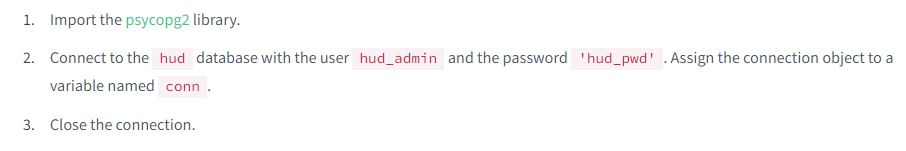

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
conn.close()`

In every Postgres engine, there is a set of internal tables Postgres uses to manage its entire structure. These tables are located in the Postgres documentation as the groups [information_schema](https://www.postgresql.org/docs/current/information-schema.html) and [system catalogs](https://www.postgresql.org/docs/current/catalogs-overview.html). These contain all the information about `data`, `names of tables`, and `types` stored in a Postgres database. For example, when we use the attribute, `cursor.description`, it is pulling information from the internal tables to display to the user.

The team at HUD has not given us details about the structure of their database. To proceed, we need to create our own detailed description of what's included. The Postgres table that contains the list of all tables in the database is named `pg_tables` and is located in the `pg_catalog` system schema. From the [documentation of the `pg_catalog.pg_tables`](https://www.postgresql.org/docs/current/view-pg-tables.html) we see that there are plenty of columns. Here are the first three:

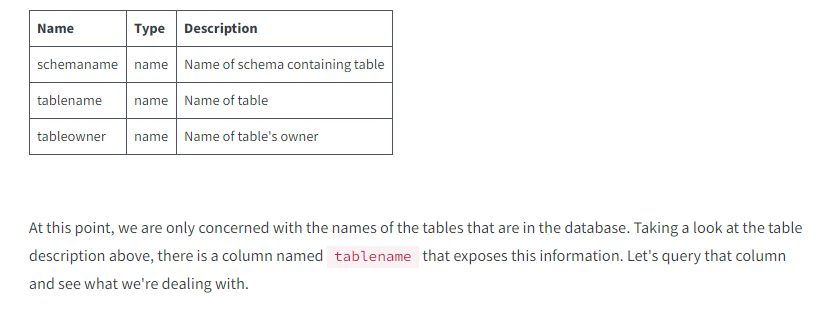

**Task**

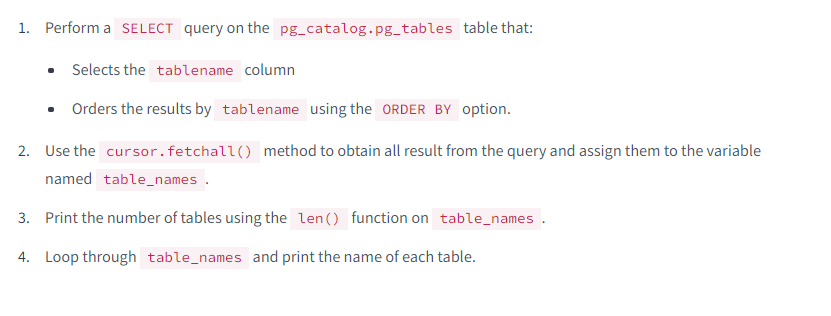

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()`

`cur.execute("""
    SELECT tablename FROM pg_catalog.pg_tables
    ORDER BY tablename;
""")`

`table_names = cur.fetchall()
print(len(table_names))`

`for name in table_names:
    print(name)`

The output above contained an overwhelming amount of tables which does not help us with our investigation of the **hud** database. The problem was that we included Postgres' the internal tables in our results.

In the output, we probably have noticed many tables that started with the `prefix pg_*`. Each table is part of the `pg_catalog` group of internal tables. These are the system catalog tables we described earlier.

Then, as we may have guessed, there is also a group of other tables under the `information_schema` name. These tables are harder to identify, though, as they follow no obvious prefix pattern. How do we know which tables are internal and which tables are user created?

Schemas can be seen as folders for separating database tables with the purpose of separating them into **isolated groups**.



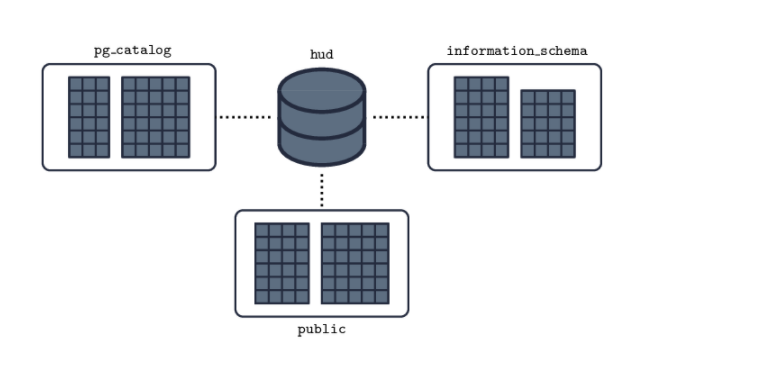

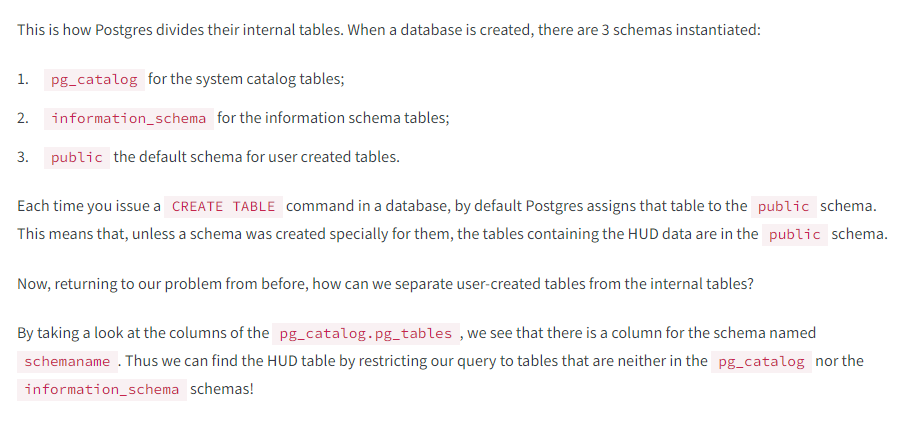

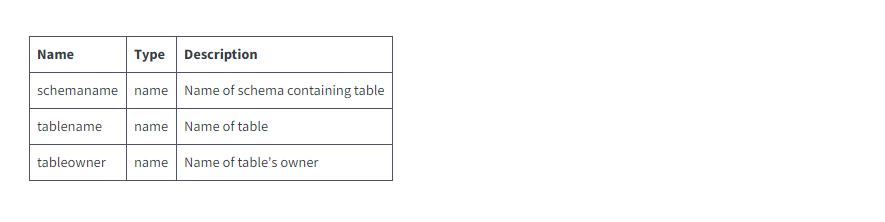

**Task**

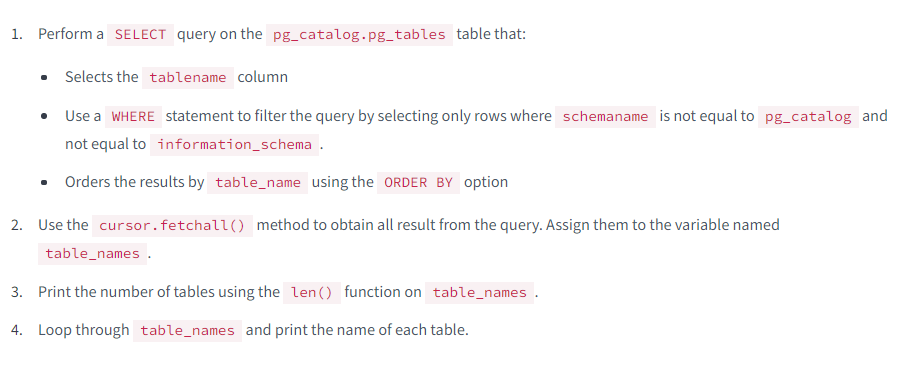

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()`

`cur.execute("""
    SELECT tablename FROM pg_catalog.pg_tables
    WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema'
    ORDER BY tablename;
""")`

`table_names = cur.fetchall()`

`print(len(table_names))`

`for table_name in table_names:
    name = table_name[0]
    print(name)`

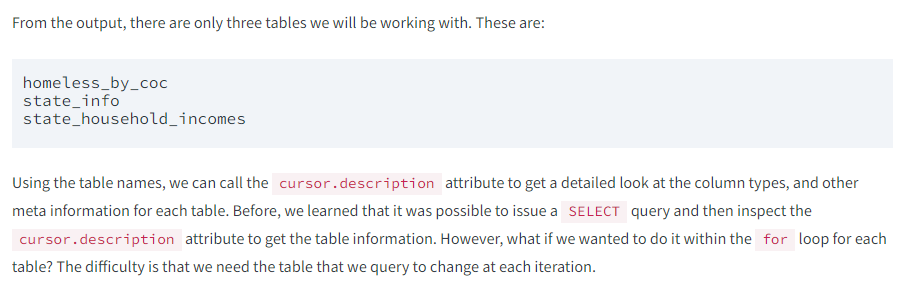

Hopefully our first thought was **not** to use the `str.format()` method. We already mentioned the issues surrounding string interpolation with `str.format()`. Even when it is for our usage only, it is a good practice to properly format queries so that this becomes an automatism for us.

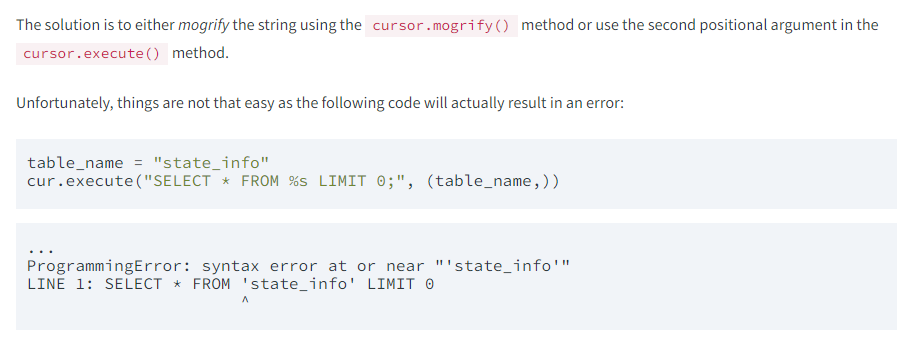

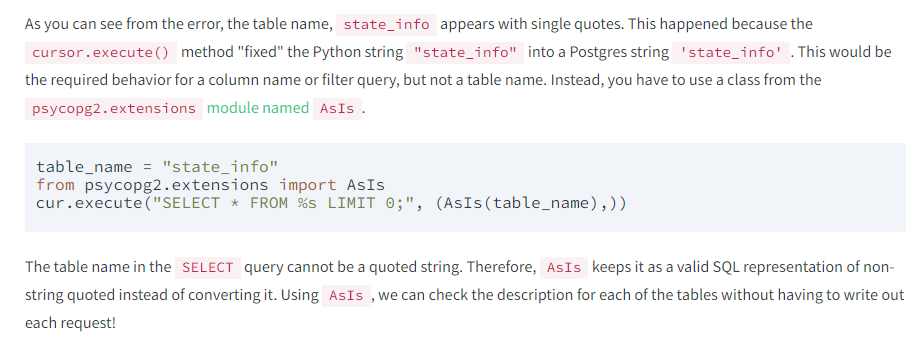

**Task**

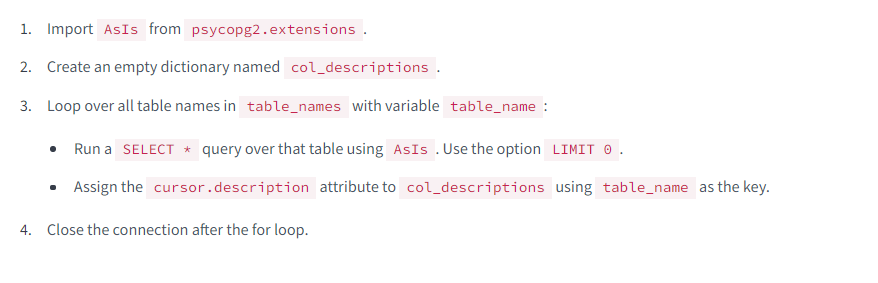

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()`

`from psycopg2.extensions import AsIs`

`col_descriptions = {}
for table_name in table_names:
    cur.execute("SELECT * FROM %s LIMIT 0;", (AsIs(table_name),))
    col_descriptions[table_name] = cur.description`

`conn.close()`

Above we found the description of each **HUD** table as a dictionary named `col_descriptions`. The following table shows the description of the `homeless_by_coc` table contained in `col_descriptions['homeless_by_coc']`:

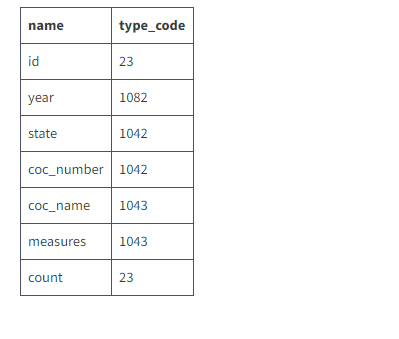

Being familiar with the `description` attribute, we should be comfortable with the metadata available. However, we are once again faced with an integer `type_code` instead of a human readable type. There is too much mental overhead when remembering what human readable types they represent (`TEXT`, `INTEGER`, or `BOOLEAN`).

We have learned how to map these type codes into human readable types. Recall that the internal table containing this information is located in the `pg_catalog` schema and it is named `pg_type`. We can refresh our memory about it by looking a [it's documentation](https://www.postgresql.org/docs/current/catalog-pg-type.html). The two columns that we are interested in are the `oid` which contain the type codes and the `typname` which contain the type name.

Let's use this table to create a dictionary for mapping type codes into human readable type names.

**Task**

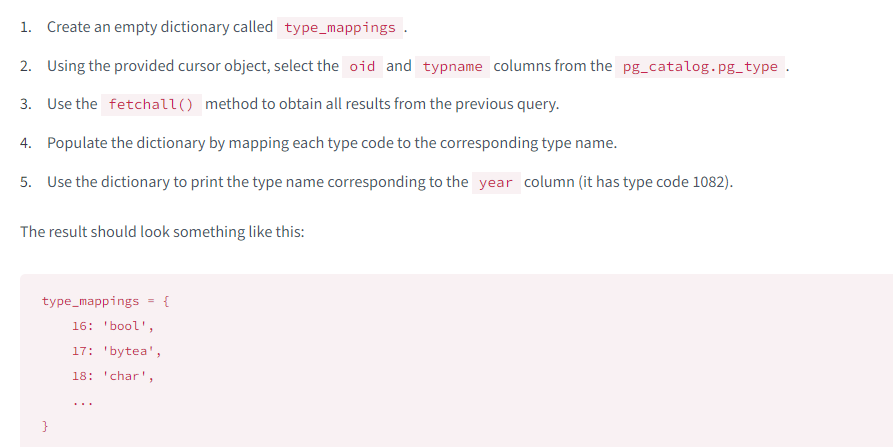

**Answer**

`import psycopg2
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()
cur.execute("SELECT oid, typname FROM pg_catalog.pg_type;")
type_mappings = { int(oid): typname for oid, typname in cur.fetchall() }
print(type_mappings[1082])`

Now we have a mapping of all type codes to their type names. Using the `type_mappings` dictionary, the types are provided without looking them up in the documentation.

Let's put all this together and create our own table descriptions. We want to rewrite the `cursor.description` attributes from a list of tuples towards something human readable. In the following exercise, we will assemble the output from the previous exercises into this dictionary:

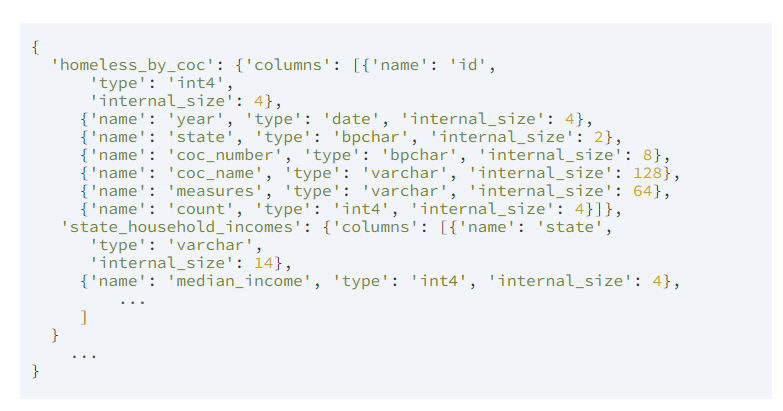

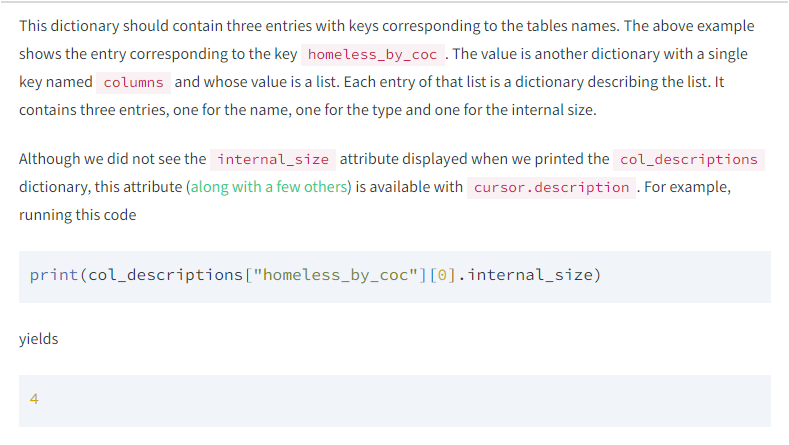

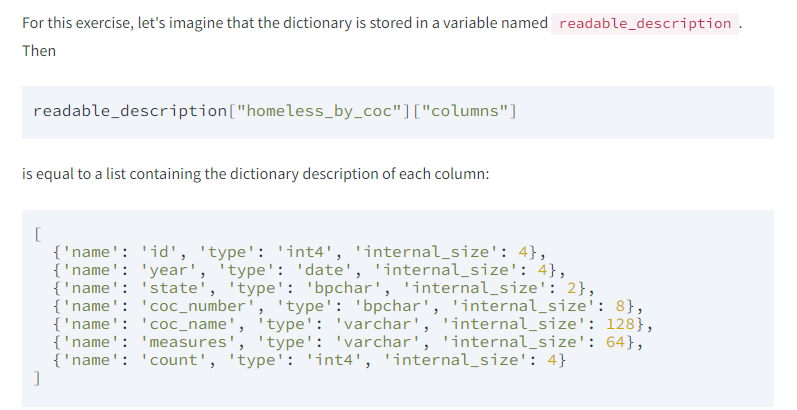

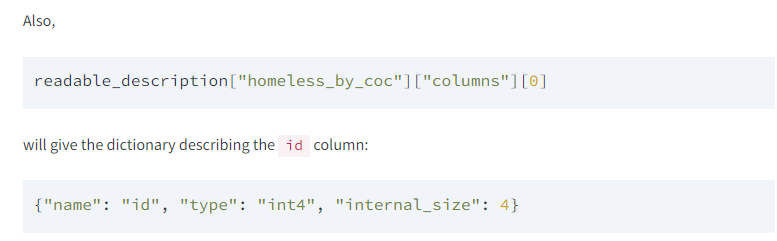

**Task**

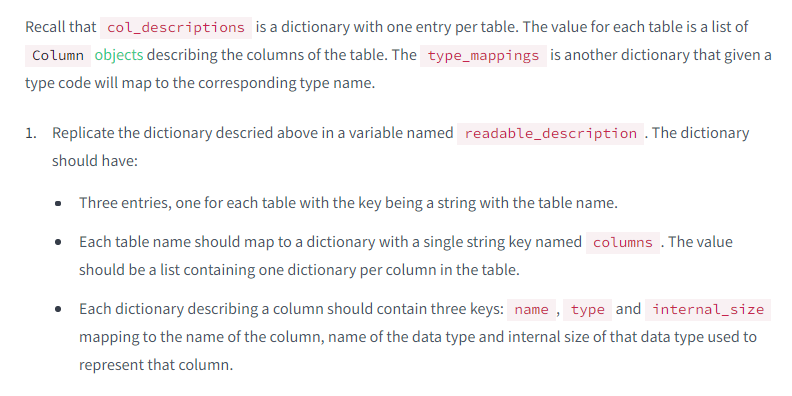

**Answer**

`readable_description = {}
for table_name in col_descriptions:
    readable_description[table_name] = {
        "columns": [
            {
                "name": col.name, 
                "type": type_mappings[col.type_code], 
                "internal_size": col.internal_size
            }
            for col in col_descriptions[table_name]
        ]
    }`

Things are starting to come together. Now, to complete our investigation we want to provide some additional information about the rows in our tables. Let's provide our description with the number of rows in the table.

We can find the number of rows using the `COUNT()` aggregate function. This is extremely similar to SQLite's aggregate function as well as other implementations of the SQL syntax. If we want to learn more about Postgres' aggregate functions, please check the [Postgres aggregate functions tutorial](https://www.postgresql.org/docs/12/tutorial-agg.html).

Here's how we would use the `COUNT()` function in Postgres to count the number of rows in a table:

`SELECT COUNT(*) FROM example_table;`

Our objective is to extend the description that we created above so that each table description contains a new key `number_of_rows` mapping to the number of rows in that table.

Our description table should look like:

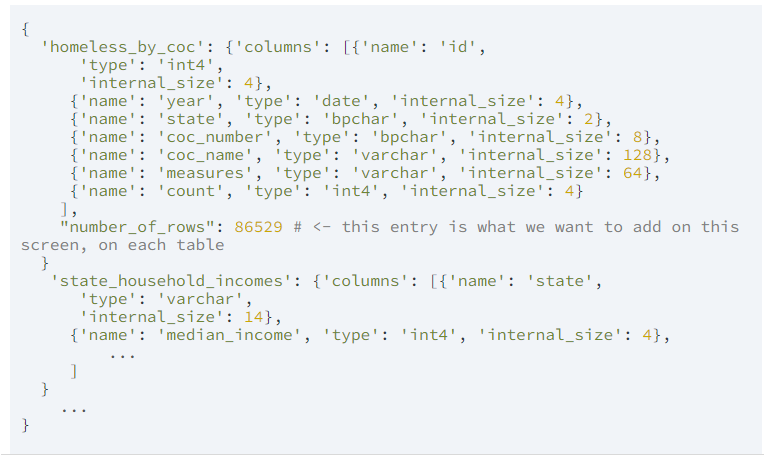

**Task**

The dictionary `readable_description` that we have created, we just need to update it by adding an entry for the number of rows in each table.

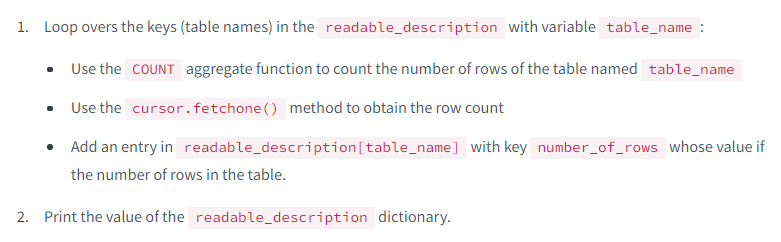

**Answer**

`import psycopg2
from psycopg2.extensions import AsIs
conn = psycopg2.connect("dbname=hud user=hud_admin password=hud_pwd")
cur = conn.cursor()`

`for table_name in readable_description.keys():
    cur.execute("SELECT COUNT(*) FROM %s;", [AsIs(table_name)])
    readable_description[table_name]["number_of_rows"] = cur.fetchone()[0]`
    
`print(readable_description)`

Abpve we created a human readable description of the tables in the HUD database. However, when we printed the dictionary, it was actually not easy to read at all. It looked something like this:

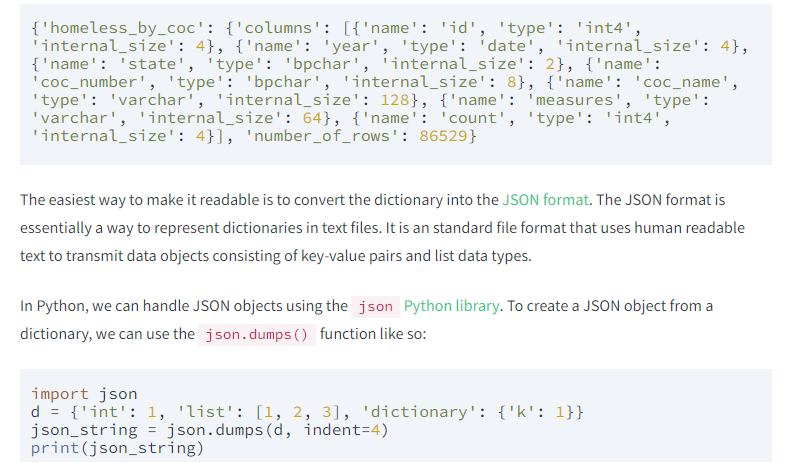

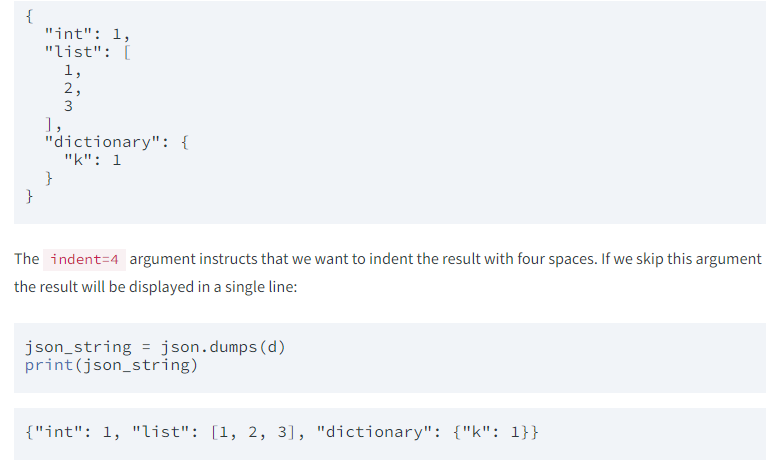

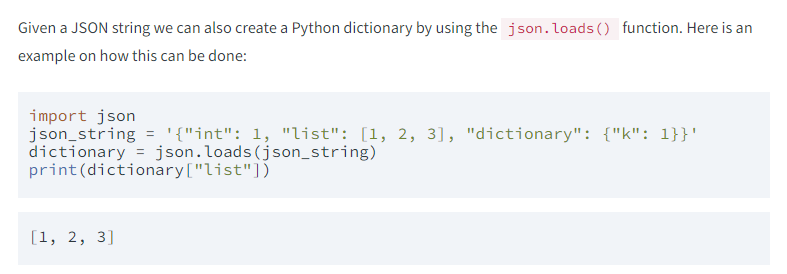

Note that contrary to Python, the JSON format only accepts double quotes — "" — for representing strings. If our textual representation of the dictionary uses single quotes — '' — it will cause an error.

**Task**

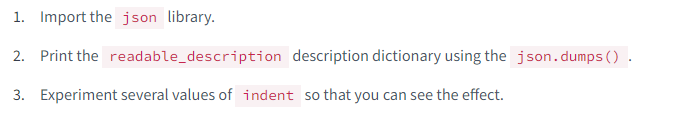

**Answer**

`import json
json_str = json.dumps(readable_description, indent=2)
print(json_str)`

In this file, we went from having no knowledge about a database and its tables to having a human readable description of the tables we will be working with. We learned more about Postgres's internal tables and the schemas used to organize them. Then, we applied our knowledge to build our own description dictionary from scratch.

We learned about the JSON format for giving human readable textual representation of dictionaries. The JSON format is very popular in a lot of applications so it is a valuable skill to have.

In the next file, we will be building on our understanding of the tables and we will learn how to debug Postgres queries. Using internal tables and Postgres specific commands, we will analyze how the Postgres engine runs analysis queries. Then, we will use that knowledge to determine what steps we need to take to make them more efficient and faster to run.